In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import sys
import os
import json
import torch
import yaml
import numpy as np
import cv2
import copy
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_utils import get_camera_intrinsic, get_origin

In [66]:
os.chdir('/workspace/plane-nerf')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148"
DATA_PATH = "/workspace/plane-nerf/data/jackal_floor_evaluation_data"
TRANSFORM_PATH = DATA_PATH + "/transforms.json"
with open(TRANSFORM_PATH, "r") as f:
    transforms = json.load(f)

In [67]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, checkpoint_path, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )
pipeline.eval()
pipeline.datamanager.setup_train()

tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 300 images.

In [68]:
for camera, batch in pipeline.datamanager.fixed_indices_train_dataloader:
    break

print(camera)

pose = transforms["frames"][0]["transform_matrix"]

pose = pose[:3][:4]
pose = np.array([pose])
pose = torch.from_numpy(pose).float().to("cpu")
print(pose)

from plane_nerf.inerf_utils import transform_original_space_to_pose

new_camera_pose = transform_original_space_to_pose(pose, 
                                                   pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                   pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                   "opengl")
print(new_camera_pose)
camera.camera_to_worlds = new_camera_pose.float().to(pipeline.model.device)
print(camera.camera_to_worlds)
print(camera.width,camera.height)
print(camera.cx,camera.cy)

outputs = pipeline.model.get_outputs_for_camera(camera=camera)    

Cameras(camera_to_worlds=tensor([[[ 9.9999e-01,  2.5189e-03, -3.1010e-03, -6.6229e-03],
         [-3.9735e-03,  7.0776e-01, -7.0644e-01, -9.9245e-01],
         [ 4.1534e-04,  7.0645e-01,  7.0777e-01,  5.2963e-04]]],
       device='cuda:0'), fx=tensor([[1128.5714]], device='cuda:0'), fy=tensor([[1128.5714]], device='cuda:0'), cx=tensor([[640.]], device='cuda:0'), cy=tensor([[360.]], device='cuda:0'), width=tensor([[1280]], device='cuda:0'), height=tensor([[720]], device='cuda:0'), distortion_params=tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0'), camera_type=tensor([[1]], device='cuda:0'), times=None, metadata={})
tensor([[[ 0.7716,  0.4500, -0.4496, -1.4164],
         [-0.6361,  0.5458, -0.5454, -1.4354],
         [ 0.0000,  0.7068,  0.7074,  2.5000]]])
tensor([[[ 7.7162e-01,  4.4966e-01, -4.4989e-01, -4.7102e-01],
         [-6.3608e-01,  5.4622e-01, -5.4502e-01, -4.7795e-01],
         [ 6.6004e-04,  7.0672e-01,  7.0749e-01,  6.1792e-05]]])
tensor([[[ 7.7162e-01,  4.4966e-01, -4.49

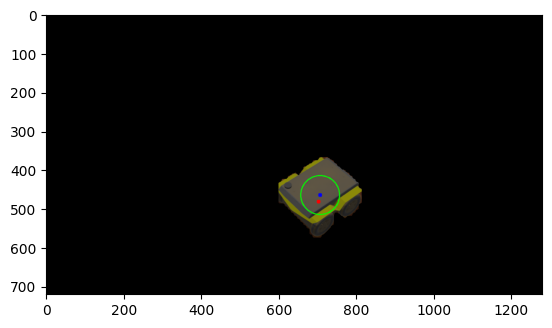

In [69]:
img = outputs["rgb"].cpu().numpy()
img = img * 255
img = img.astype(np.uint8)
mask = cv2.imread(os.path.join(DATA_PATH, transforms["frames"][0]["mask_path"]), cv2.IMREAD_GRAYSCALE)
img = cv2.bitwise_and(img, img, mask=mask)

#Find mask centroid
M = cv2.moments(mask)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])
#Draw red circle at centroid
img = cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)

#Draw green circle around centroid
img = cv2.circle(img, (cx, cy), 50, (0, 255, 0), 2)

#Find orign pixel
intrinsic = get_camera_intrinsic(camera)
torch_pose = np.array(pose)
torch_pose = np.concatenate((torch_pose[0], np.array([[0,0,0,1]])), axis=0)
torch_pose = np.array([torch_pose])
torch_pose = torch.from_numpy(torch_pose).float().to("cpu")
origin = get_origin(torch_pose, intrinsic)
origin = origin.cpu().numpy()[0]
img = cv2.circle(img, (int(origin[0]), int(origin[1])), 5, (255, 0, 0), -1)
plt.imshow(img)

#Save img
img = Image.fromarray(img)
img.save("output.png")